In [1]:
import pandas as pd
import librosa as lr
import soundfile as sf
import numpy as np
import os
import parselmouth
from parselmouth.praat import call
import seaborn as sns
import matplotlib.pyplot as plt
from pydub import AudioSegment, effects

C:\Users\Gonza\AppData\Roaming\Python\Python37\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Greek Dataset - Feature Engineering

Preprocessing function to compute F0, Energy, 

In [12]:
def preprocessing(id_,dataset,y,sr,feature,window=25,hop=10,type_='micro'):
    features_dict_micro = {}
    features_dict_macro = {}
    samples = int(sr*(window*10**(-3)))
    frames = int((len(y))/samples)
    features_dict_micro['id'] = id_
    features_dict_micro['dataset'] = dataset 
    features_dict_macro['id'] = id_
    features_dict_macro['emotion'] = dataset 
    sound = parselmouth.Sound(y)
    pitch = call(sound, "To Pitch", 0.0, 65,2093)
    meanF0 = call(pitch, "Get mean", 0, 0, "Hertz")
    stdF0 = call(pitch, "Get standard deviation", 0 ,0, 'Hertz')
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", 65, 2093)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    features_dict_macro['mean_F0'] = meanF0
    features_dict_macro['std_F0'] = stdF0
    features_dict_macro['hnr'] = hnr
    features_dict_macro['localJitter'] = localJitter
    features_dict_macro['localabsoluteJitter'] = localabsoluteJitter
    features_dict_macro['rapJitter'] = rapJitter
    features_dict_macro['ppq5Jitter'] = ppq5Jitter
    features_dict_macro['ddpJitter'] = ddpJitter
    features_dict_macro['localShimmer'] = localShimmer
    features_dict_macro['localdbShimmer'] = localdbShimmer
    features_dict_macro['apq3Shimmer'] = apq3Shimmer
    features_dict_macro['aqpq5Shimmer'] = aqpq5Shimmer
    features_dict_macro['apq11Shimmer'] = apq11Shimmer
    features_dict_macro['ddaShimmer'] = ddaShimmer

    
    if feature == 'fo':
        fo = lr.yin(y,fmin=65,fmax=2093,sr=sr,win_length=int(sr*window*10**(-3)),hop_length=int(sr*hop*10**(-3)));
        features_dict_micro['original_frames'] = len(fo)
        for i in range(len(fo)):
            features_dict_micro[f'fo{i}'] = fo[i];
    if feature == 'rms':
        rms = lr.feature.rms(y,frame_length=int(sr*window*10**(-3)),hop_length=int(sr*hop*10**(-3)))
        features_dict_micro['original_frames'] = len(rms[0])
        for i in range(len(rms[0])):
            features_dict_micro[f'rms{i}'] = rms[0][i];
            
    if feature == 'zcr':
        zcr = lr.feature.zero_crossing_rate(y,frame_length=int(sr*window*10**(-3)),hop_length=int(sr*hop*10**(-3)))
        features_dict_micro['original_frames'] = len(zcr[0])
        for i in range(len(zcr[0])):
            features_dict_micro[f'zcr{i}'] = zcr[0][i];
    """
    if feature == 'spectral_centroid':
        rms = lr.feature.rms(y,frame_length=int(sr*window*10**(-3)),hop_length=int(sr*hop*10**(-3)))
        features_dict_micro['original_frames'] = len(rms[0])
        for i in range(len(rms[0])):
            features_dict_micro[f'rms{i}'] = rms[0][i];
    """        
    
    if type_ == 'micro':    
        return features_dict_micro
    elif type_ == 'macro':
        return features_dict_macro
        
            
   

### F0

In [13]:
#Making dataframe with 1 file
y,sr = lr.load('Test\\Griego\\Greek1.wav',sr=44100)
dictionario = preprocessing('Greek1','Griego',y,sr,feature='fo')
df_fo = pd.DataFrame(data=dictionario,index= [0] )

In [14]:
df_fo

,id,dataset,original_frames,fo0,fo1,fo2,fo3,fo4,fo5,fo6,...,fo371,fo372,fo373,fo374,fo375,fo376,fo377,fo378,fo379,fo380
0,Greek1,Griego,381,213.167076,479.309559,217.842553,224.974843,230.096085,234.30323,239.089149,...,142.158947,136.762855,137.112398,149.915747,147.304219,145.526776,159.296625,126.24343,80.950757,90.544497


In [15]:
for root, dirs, files in os.walk('Test', topdown=False):
    if files:
        for name in files:
            dataset = root.split('\\')[-1]
            if dataset == 'German':
                y,sr = lr.load(root + '\\' + name,sr=16000)
            else:
                y,sr = lr.load(root + '\\' + name,sr=44100)
            name_ = name.split('.')[0]
            dic = preprocessing(name_,dataset,y,sr,feature='fo')
            df_fo = df_fo.append(dic,ignore_index=True)
   

Let's fill nan values with the last observation. Thats the best option since we care about variations

In [16]:
df_fo = df_fo.fillna(method='ffill',axis=1)

In [17]:
df_fo

,id,dataset,original_frames,fo0,fo1,fo2,fo3,fo4,fo5,fo6,...,fo476,fo477,fo478,fo479,fo480,fo481,fo482,fo483,fo484,fo485
0,Greek1,Griego,381,213.167,479.31,217.843,224.975,230.096,234.303,239.089,...,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445
1,German1,German,162,64.7773,2285.71,2285.71,2285.71,67.2149,64.7773,79.554,...,2285.71,2285.71,2285.71,2285.71,2285.71,2285.71,2285.71,2285.71,2285.71,2285.71
2,German2,German,187,82.6332,2075.22,2079.62,64.7773,64.7773,64.7773,70.8103,...,1495.28,1495.28,1495.28,1495.28,1495.28,1495.28,1495.28,1495.28,1495.28,1495.28
3,German3,German,181,1389.82,1358.4,711.529,733.309,1606.07,152.248,152.61,...,1463.5,1463.5,1463.5,1463.5,1463.5,1463.5,1463.5,1463.5,1463.5,1463.5
4,Greek1,Griego,381,213.167,479.31,217.843,224.975,230.096,234.303,239.089,...,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445,90.5445
5,Greek2,Griego,333,349.107,323.523,340.893,341.83,343.276,342.498,341.397,...,83.07,83.07,83.07,83.07,83.07,83.07,83.07,83.07,83.07,83.07
6,Greek3,Griego,486,635.322,151.72,1535.2,339.659,307.845,312.229,313.236,...,577.496,610.36,1676,1720.55,1741.62,1594.26,1816.18,1758.75,1801.77,1714.56


### Macro Features

In [20]:
y,sr = lr.load('Test\\Griego\\Greek1.wav',sr=44100)
dictionario_macro = preprocessing('Greek1','Griego',y,sr,feature='fo',type_='macro')
df_macro = pd.DataFrame(data=dictionario_macro,index= [0] )

In [21]:
df_macro

,id,emotion,mean_F0,std_F0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,aqpq5Shimmer,apq11Shimmer,ddaShimmer
0,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,0.096258,0.977362,0.030367,0.052755,0.118999,0.091101


In [22]:
for root, dirs, files in os.walk('Test', topdown=False):
    if files:
        for name in files:
            dataset = root.split('\\')[-1]
            if dataset == 'German':
                y,sr = lr.load(root + '\\' + name,sr = 16000)
                
            else:
                y,sr = lr.load(root + '\\' + name,sr = 44100)
                
            dataset = root.split('\\')[-1]
            name_ = name.split('.')[0]
            dic_macro = preprocessing(name_,dataset,y,sr,feature='fo',type_='macro')
            df_macro = df_macro.append(dic_macro,ignore_index=True)

In [23]:
df_macro

,id,emotion,mean_F0,std_F0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,aqpq5Shimmer,apq11Shimmer,ddaShimmer
0,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,0.096258,0.977362,0.030367,0.052755,0.118999,0.091101
1,German1,German,844.050246,119.994253,7.034966,0.017360,0.000021,0.006913,0.006952,0.020740,0.089260,0.946148,0.029713,0.048678,0.109783,0.089139
2,German2,German,951.747362,161.199870,7.285411,0.021995,0.000024,0.009522,0.010921,0.028567,0.105233,0.933915,0.037270,0.047856,0.077539,0.111809
3,German3,German,1012.528826,201.184822,5.276675,0.020344,0.000021,0.007090,0.009025,0.021270,0.121169,1.035557,0.047657,0.066715,0.120996,0.142970
4,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,0.096258,0.977362,0.030367,0.052755,0.118999,0.091101
5,Greek2,Griego,355.826280,64.204857,12.444178,0.013433,0.000038,0.005347,0.006422,0.016041,0.101472,1.077811,0.035061,0.055602,0.107266,0.105182
6,Greek3,Griego,377.791354,119.430781,13.886094,0.012129,0.000032,0.004736,0.005927,0.014207,0.081487,0.849618,0.026459,0.041861,0.082318,0.079378


No we calculate some other statistics using the original frame length

In [24]:
fo_median = []
fo_max = []
fo_min = []

for i in range(df_fo.shape[0]):
    fo_median.append(df_fo.iloc[i,3:df_fo.original_frames[i] + 3].median())
    fo_max.append(df_fo.iloc[i,3:df_fo.original_frames[i] + 3].max())
    fo_min.append(df_fo.iloc[i,3:df_fo.original_frames[i] + 3].min())

In [25]:
df_macro['median_F0'] = fo_median
df_macro['max_F0'] = fo_max
df_macro['min_F0'] = fo_min

In [26]:
df_macro.head()

,id,emotion,mean_F0,std_F0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,aqpq5Shimmer,apq11Shimmer,ddaShimmer,median_F0,max_F0,min_F0
0,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,0.096258,0.977362,0.030367,0.052755,0.118999,0.091101,261.914830,2100.000000,64.948454
1,German1,German,844.050246,119.994253,7.034966,0.017360,0.000021,0.006913,0.006952,0.020740,0.089260,0.946148,0.029713,0.048678,0.109783,0.089139,317.776807,2285.714286,64.777328
2,German2,German,951.747362,161.199870,7.285411,0.021995,0.000024,0.009522,0.010921,0.028567,0.105233,0.933915,0.037270,0.047856,0.077539,0.111809,342.847350,2285.714286,64.777328
3,German3,German,1012.528826,201.184822,5.276675,0.020344,0.000021,0.007090,0.009025,0.021270,0.121169,1.035557,0.047657,0.066715,0.120996,0.142970,355.450585,2285.714286,90.493757
4,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,0.096258,0.977362,0.030367,0.052755,0.118999,0.091101,261.914830,2100.000000,64.948454


## Energy

In [28]:
y,sr = lr.load('Test\\Griego\\Greek1.wav',sr= 44100)

dictionario = preprocessing('Greek1','Griego',y,sr,feature='rms')
df_rms = pd.DataFrame(data=dictionario,index= [0] )
df_rms

,id,dataset,original_frames,rms0,rms1,rms2,rms3,rms4,rms5,rms6,...,rms371,rms372,rms373,rms374,rms375,rms376,rms377,rms378,rms379,rms380
0,Greek1,Griego,381,0.006464,0.011927,0.02578,0.040704,0.052819,0.062618,0.070324,...,0.013191,0.007897,0.006605,0.004775,0.002727,0.001344,0.000579,0.000375,0.000185,0.000118


In [29]:
for root, dirs, files in os.walk('Test', topdown=False):
    if files:
        for name in files:
            dataset = root.split('\\')[-1]
            if dataset == 'German':
                y,sr = lr.load(root + '\\' + name,sr = 16000)
                
            else:
                y,sr = lr.load(root + '\\' + name,sr = 44100)
                
            dataset = root.split('\\')[-1]
            name_ = name.split('.')[0]
            dic = preprocessing(name_,dataset,y,sr,feature='rms')
            df_rms = df_rms.append(dic,ignore_index=True)

In [30]:
df_rms.head()

,id,dataset,original_frames,rms0,rms1,rms2,rms3,rms4,rms5,rms6,...,rms476,rms477,rms478,rms479,rms480,rms481,rms482,rms483,rms484,rms485
0,Greek1,Griego,381,0.006464,0.011927,0.025780,0.040704,0.052819,0.062618,0.070324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,German1,German,162,0.000478,0.000478,0.000540,0.000436,0.000461,0.000441,0.000474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,German2,German,187,0.000574,0.000482,0.000419,0.000376,0.000394,0.000421,0.000404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,German3,German,181,0.001250,0.001151,0.000897,0.000639,0.001053,0.001944,0.004187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Greek1,Griego,381,0.006464,0.011927,0.025780,0.040704,0.052819,0.062618,0.070324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_rms = df_rms.fillna(method='ffill',axis=1)

In [32]:
df_rms.head()

,id,dataset,original_frames,rms0,rms1,rms2,rms3,rms4,rms5,rms6,...,rms476,rms477,rms478,rms479,rms480,rms481,rms482,rms483,rms484,rms485
0,Greek1,Griego,381,0.00646403,0.0119267,0.02578,0.0407039,0.0528189,0.0626179,0.0703242,...,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242
1,German1,German,162,0.000478053,0.000478341,0.000539926,0.000435843,0.000461113,0.000440556,0.000473998,...,0.000204223,0.000204223,0.000204223,0.000204223,0.000204223,0.000204223,0.000204223,0.000204223,0.000204223,0.000204223
2,German2,German,187,0.000573574,0.000482306,0.000418567,0.000376419,0.000394179,0.000421192,0.000404024,...,0.000373878,0.000373878,0.000373878,0.000373878,0.000373878,0.000373878,0.000373878,0.000373878,0.000373878,0.000373878
3,German3,German,181,0.00124977,0.00115074,0.00089738,0.000638671,0.00105275,0.00194372,0.00418719,...,0.000303707,0.000303707,0.000303707,0.000303707,0.000303707,0.000303707,0.000303707,0.000303707,0.000303707,0.000303707
4,Greek1,Griego,381,0.00646403,0.0119267,0.02578,0.0407039,0.0528189,0.0626179,0.0703242,...,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242,0.000118242


In [33]:
rms_mean = []
rms_median = []
rms_std = []
rms_max = []
rms_min = []

for i in range(df_rms.shape[0]):
    rms_mean.append(df_rms.iloc[i,3:df_rms.original_frames[i] + 3].mean())
    rms_median.append(df_rms.iloc[i,3:df_rms.original_frames[i] + 3].median())
    rms_std.append(df_rms.iloc[i,3:df_rms.original_frames[i] + 3].std()) #Cambiar a desvio logaritmico
    rms_max.append(df_rms.iloc[i,3:df_rms.original_frames[i] + 3].max())
    rms_min.append(df_rms.iloc[i,3:df_rms.original_frames[i] + 3].min())

In [34]:
df_macro['mean_RMS'] = rms_mean
df_macro['median_RMS'] = rms_median
df_macro['std_RMS'] = rms_std
df_macro['max_RMS'] = rms_max
df_macro['min_RMS'] = rms_min

In [35]:
df_macro.head()

,id,emotion,mean_F0,std_F0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,...,apq11Shimmer,ddaShimmer,median_F0,max_F0,min_F0,mean_RMS,median_RMS,std_RMS,max_RMS,min_RMS
0,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,...,0.118999,0.091101,261.914830,2100.000000,64.948454,0.055104,0.038736,0.055594,0.321054,0.000118
1,German1,German,844.050246,119.994253,7.034966,0.017360,0.000021,0.006913,0.006952,0.020740,...,0.109783,0.089139,317.776807,2285.714286,64.777328,0.053626,0.031750,0.055816,0.263240,0.000172
2,German2,German,951.747362,161.199870,7.285411,0.021995,0.000024,0.009522,0.010921,0.028567,...,0.077539,0.111809,342.847350,2285.714286,64.777328,0.046043,0.020129,0.060814,0.285108,0.000064
3,German3,German,1012.528826,201.184822,5.276675,0.020344,0.000021,0.007090,0.009025,0.021270,...,0.120996,0.142970,355.450585,2285.714286,90.493757,0.088171,0.040043,0.097446,0.340465,0.000173
4,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,...,0.118999,0.091101,261.914830,2100.000000,64.948454,0.055104,0.038736,0.055594,0.321054,0.000118


### Zero Crossing Rate

In [36]:
y,sr = lr.load('Test\\Griego\\Greek1.wav',sr=44100)
dictionario_zcr = preprocessing('Greek1','Griego',y,sr,feature='zcr')
df_zcr = pd.DataFrame(data=dictionario_zcr,index= [0] )
df_zcr

,id,dataset,original_frames,zcr0,zcr1,zcr2,zcr3,zcr4,zcr5,zcr6,...,zcr371,zcr372,zcr373,zcr374,zcr375,zcr376,zcr377,zcr378,zcr379,zcr380
0,Greek1,Griego,381,0.045372,0.061706,0.046279,0.027223,0.020871,0.023593,0.023593,...,0.04265,0.029946,0.029946,0.037205,0.049002,0.061706,0.058076,0.051724,0.043557,0.029038


In [37]:
for root, dirs, files in os.walk('Test', topdown=False):
    if files:
        for name in files:
            
            dataset = root.split('\\')[-1]
            if dataset == 'German':
                y,sr = lr.load(root + '\\' + name,sr = 16000)      
            else:
                y,sr = lr.load(root + '\\' + name,sr = 44100)
            dataset = root.split('\\')[-1]
            name_ = name.split('.')[0]
            dic = preprocessing(name_,dataset,y,sr,feature='zcr')
            df_zcr = df_zcr.append(dic,ignore_index=True)

In [38]:
df_zcr.head()

,id,dataset,original_frames,zcr0,zcr1,zcr2,zcr3,zcr4,zcr5,zcr6,...,zcr476,zcr477,zcr478,zcr479,zcr480,zcr481,zcr482,zcr483,zcr484,zcr485
0,Greek1,Griego,381,0.045372,0.061706,0.046279,0.027223,0.020871,0.023593,0.023593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,German1,German,162,0.007500,0.007500,0.005000,0.017500,0.045000,0.040000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,German2,German,187,0.010000,0.010000,0.020000,0.022500,0.015000,0.010000,0.017500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,German3,German,181,0.157500,0.270000,0.205000,0.122500,0.067500,0.107500,0.217500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Greek1,Griego,381,0.045372,0.061706,0.046279,0.027223,0.020871,0.023593,0.023593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_zcr = df_zcr.fillna(method='ffill',axis=1)

In [40]:
df_zcr.head()

,id,dataset,original_frames,zcr0,zcr1,zcr2,zcr3,zcr4,zcr5,zcr6,...,zcr476,zcr477,zcr478,zcr479,zcr480,zcr481,zcr482,zcr483,zcr484,zcr485
0,Greek1,Griego,381,0.0453721,0.061706,0.0462795,0.0272232,0.0208711,0.0235935,0.0235935,...,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381
1,German1,German,162,0.0075,0.0075,0.005,0.0175,0.045,0.04,0,...,0,0,0,0,0,0,0,0,0,0
2,German2,German,187,0.01,0.01,0.02,0.0225,0.015,0.01,0.0175,...,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005
3,German3,German,181,0.1575,0.27,0.205,0.1225,0.0675,0.1075,0.2175,...,0,0,0,0,0,0,0,0,0,0
4,Greek1,Griego,381,0.0453721,0.061706,0.0462795,0.0272232,0.0208711,0.0235935,0.0235935,...,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381,0.0290381


In [41]:
zcr_mean = []
zcr_median = []
zcr_std = []
zcr_max = []
zcr_min = []

for i in range(df_zcr.shape[0]):
    zcr_mean.append(df_zcr.iloc[i,3:df_zcr.original_frames[i] + 3].mean())
    zcr_median.append(df_zcr.iloc[i,3:df_zcr.original_frames[i] + 3].median())
    zcr_std.append(df_zcr.iloc[i,3:df_zcr.original_frames[i] + 3].std()) #Cambiar a desvio logaritmico
    zcr_max.append(df_zcr.iloc[i,3:df_zcr.original_frames[i] + 3].max())
    zcr_min.append(df_zcr.iloc[i,3:df_zcr.original_frames[i] + 3].min())

In [42]:
df_macro['mean_ZCR'] = zcr_mean
df_macro['median_ZCR'] = zcr_median
df_macro['std_ZCR'] = zcr_std
df_macro['max_ZCR'] = zcr_max
df_macro['min_ZCR'] = zcr_min

#### Frequency [Mel]

In [43]:
def mel(f):
    mel = 1127*np.log(1+ f/700)
    return mel

In [44]:
df_macro.columns

Index(['id', 'emotion', 'mean_F0', 'std_F0', 'hnr', 'localJitter',
       'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
       'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'aqpq5Shimmer',
       'apq11Shimmer', 'ddaShimmer', 'median_F0', 'max_F0', 'min_F0',
       'mean_RMS', 'median_RMS', 'std_RMS', 'max_RMS', 'min_RMS', 'mean_ZCR',
       'median_ZCR', 'std_ZCR', 'max_ZCR', 'min_ZCR'],
      dtype='object')

In [45]:
df_macro['mean_F0_mel'] = df_macro.mean_F0.apply(lambda x:mel(x))
df_macro['std_F0_mel'] = df_macro.std_F0.apply(lambda x:mel(x))
df_macro['max_F0_mel'] = df_macro.max_F0.apply(lambda x:mel(x))
df_macro['min_F0_mel'] = df_macro.min_F0.apply(lambda x:mel(x))
df_macro['median_F0_mel'] = df_macro.median_F0.apply(lambda x:mel(x))
df_macro['min_max_F0_difference'] = df_macro.max_F0_mel - df_macro.min_F0_mel

In [46]:
df_macro.head()

,id,emotion,mean_F0,std_F0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,...,median_ZCR,std_ZCR,max_ZCR,min_ZCR,mean_F0_mel,std_F0_mel,max_F0_mel,min_F0_mel,median_F0_mel,min_max_F0_difference
0,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,...,0.045372,0.084059,0.553539,0.009982,384.630510,148.081667,1562.353745,99.996586,358.211966,1462.357159
1,German1,German,844.050246,119.994253,7.034966,0.017360,0.000021,0.006913,0.006952,0.020740,...,0.132500,0.134058,0.670000,0.000000,891.551598,178.310556,1634.729226,99.744438,421.831132,1534.984788
2,German2,German,951.747362,161.199870,7.285411,0.021995,0.000024,0.009522,0.010921,0.028567,...,0.117500,0.125802,0.595000,0.000000,967.539281,233.566557,1634.729226,99.744438,449.255731,1534.984788
3,German3,German,1012.528826,201.184822,5.276675,0.020344,0.000021,0.007090,0.009025,0.021270,...,0.147500,0.101088,0.515000,0.000000,1008.266118,284.714046,1634.729226,137.017757,462.794339,1497.711469
4,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,...,0.045372,0.084059,0.553539,0.009982,384.630510,148.081667,1562.353745,99.996586,358.211966,1462.357159


### Summary of dataframes and export '.csv'

In [47]:
df_macro = df_macro.drop_duplicates()
df_macro.head()

,id,emotion,mean_F0,std_F0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,...,median_ZCR,std_ZCR,max_ZCR,min_ZCR,mean_F0_mel,std_F0_mel,max_F0_mel,min_F0_mel,median_F0_mel,min_max_F0_difference
0,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,...,0.045372,0.084059,0.553539,0.009982,384.630510,148.081667,1562.353745,99.996586,358.211966,1462.357159
1,German1,German,844.050246,119.994253,7.034966,0.017360,0.000021,0.006913,0.006952,0.020740,...,0.132500,0.134058,0.670000,0.000000,891.551598,178.310556,1634.729226,99.744438,421.831132,1534.984788
2,German2,German,951.747362,161.199870,7.285411,0.021995,0.000024,0.009522,0.010921,0.028567,...,0.117500,0.125802,0.595000,0.000000,967.539281,233.566557,1634.729226,99.744438,449.255731,1534.984788
3,German3,German,1012.528826,201.184822,5.276675,0.020344,0.000021,0.007090,0.009025,0.021270,...,0.147500,0.101088,0.515000,0.000000,1008.266118,284.714046,1634.729226,137.017757,462.794339,1497.711469
5,Greek2,Griego,355.826280,64.204857,12.444178,0.013433,0.000038,0.005347,0.006422,0.016041,...,0.060799,0.086748,0.524501,0.010889,463.195431,98.900511,1275.056162,100.809727,471.710610,1174.246435


In [48]:
df_macro.columns

Index(['id', 'emotion', 'mean_F0', 'std_F0', 'hnr', 'localJitter',
       'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
       'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'aqpq5Shimmer',
       'apq11Shimmer', 'ddaShimmer', 'median_F0', 'max_F0', 'min_F0',
       'mean_RMS', 'median_RMS', 'std_RMS', 'max_RMS', 'min_RMS', 'mean_ZCR',
       'median_ZCR', 'std_ZCR', 'max_ZCR', 'min_ZCR', 'mean_F0_mel',
       'std_F0_mel', 'max_F0_mel', 'min_F0_mel', 'median_F0_mel',
       'min_max_F0_difference'],
      dtype='object')

In [49]:
df_macro_greek = df_macro[df_macro.emotion == 'Griego']
df_macro_german = df_macro[df_macro.emotion == 'German']

In [50]:
df_macro_greek[['id','mean_F0_mel', 'std_F0_mel','median_F0_mel', 'mean_RMS', 'std_RMS','median_RMS', 'mean_ZCR',
       'std_ZCR','median_ZCR','localJitter','localShimmer']]

,id,mean_F0_mel,std_F0_mel,median_F0_mel,mean_RMS,std_RMS,median_RMS,mean_ZCR,std_ZCR,median_ZCR,localJitter,localShimmer
0,Greek1,384.630510,148.081667,358.211966,0.055104,0.055594,0.038736,0.066191,0.084059,0.045372,0.017834,0.096258
5,Greek2,463.195431,98.900511,471.710610,0.078831,0.074981,0.051358,0.083828,0.086748,0.060799,0.013433,0.101472
6,Greek3,486.400632,177.535854,467.996222,0.044615,0.049079,0.033644,0.086726,0.070551,0.068512,0.012129,0.081487


In [51]:
df_macro_german.std_ZCR

1    0.134058
2    0.125802
3    0.101088
Name: std_ZCR, dtype: float64

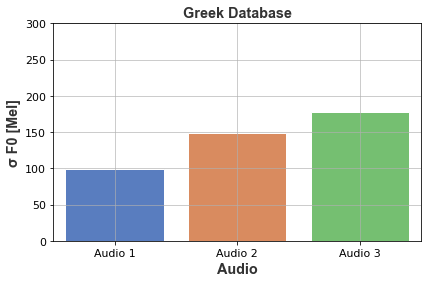

In [52]:
dims = (6.6,4)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot(x=['Audio 1','Audio 2','Audio 3'],y=df_macro_greek.std_F0_mel.sort_values(),palette='muted')
    #g = sns.barplot('Script_vs_Aurora_Error','value',hue='variable',data=script_vs_aurora_melt,palette=['#DB845B', '#5B73DB'],ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'])
    #g = sns.barplot('Script_vs_Aurora_Error','Error Mediana',data=script_vs_aurora,color='#5B73DB',ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'],label='Mediana')
    g.set_xlabel('Audio',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('σ F0 [Mel]',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,50,100,150,200,250,300])
    g.set_title('Greek Database',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Audio 1', 'Audio 2','Audio 3'],size=11)
    g.set_yticklabels([0,50,100,150,200,250,300],size=11)
    g.grid(alpha=0.8)

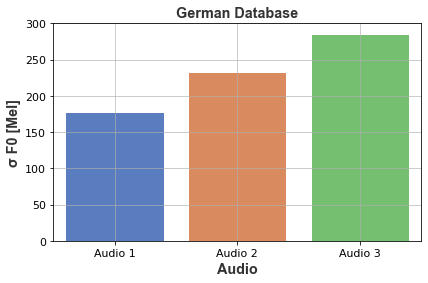

In [53]:
dims = (6.6,4)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot(x=['Audio 1','Audio 2','Audio 3'],y=df_macro_german.std_F0_mel.sort_values(),palette='muted')
    #g = sns.barplot('Script_vs_Aurora_Error','value',hue='variable',data=script_vs_aurora_melt,palette=['#DB845B', '#5B73DB'],ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'])
    #g = sns.barplot('Script_vs_Aurora_Error','Error Mediana',data=script_vs_aurora,color='#5B73DB',ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'],label='Mediana')
    g.set_xlabel('Audio',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('σ F0 [Mel]',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,50,100,150,200,250,300])
    g.set_title('German Database',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Audio 1', 'Audio 2','Audio 3'],size=11)
    g.set_yticklabels([0,50,100,150,200,250,300],size=11)
    g.grid(alpha=0.8)

In [54]:
df_macro_greek

,id,emotion,mean_F0,std_F0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,...,median_ZCR,std_ZCR,max_ZCR,min_ZCR,mean_F0_mel,std_F0_mel,max_F0_mel,min_F0_mel,median_F0_mel,min_max_F0_difference
0,Greek1,Griego,284.729899,98.292358,12.446877,0.017834,0.000064,0.007463,0.008232,0.022388,...,0.045372,0.084059,0.553539,0.009982,384.630510,148.081667,1562.353745,99.996586,358.211966,1462.357159
5,Greek2,Griego,355.826280,64.204857,12.444178,0.013433,0.000038,0.005347,0.006422,0.016041,...,0.060799,0.086748,0.524501,0.010889,463.195431,98.900511,1275.056162,100.809727,471.710610,1174.246435
6,Greek3,Griego,377.791354,119.430781,13.886094,0.012129,0.000032,0.004736,0.005927,0.014207,...,0.068512,0.070551,0.494555,0.012704,486.400632,177.535854,1562.353745,99.996586,467.996222,1462.357159


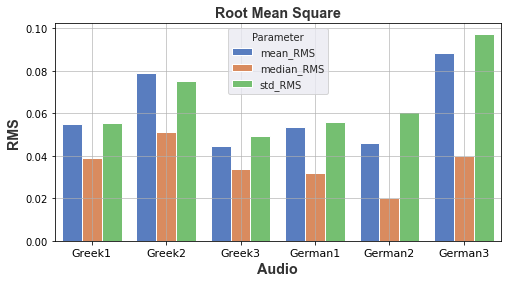

In [61]:
df_macro_rms = df_macro[['id','mean_RMS','median_RMS','std_RMS']]
df_macro_rms_melt = pd.melt(df_macro_rms,id_vars=['id'],value_vars=['mean_RMS', 'median_RMS','std_RMS'])
df_macro_rms_melt.rename(columns={'variable':'Parameter'},inplace=True)
dims = (8,4)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot(x=df_macro_rms_melt.id,y=df_macro_rms_melt.value,hue=df_macro_rms_melt.Parameter,palette='muted',order=['Greek1','Greek2','Greek3','German1','German2','German3'])
    #g = sns.barplot('Script_vs_Aurora_Error','value',hue='variable',data=script_vs_aurora_melt,palette=['#DB845B', '#5B73DB'],ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'])
    #g = sns.barplot('Script_vs_Aurora_Error','Error Mediana',data=script_vs_aurora,color='#5B73DB',ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'],label='Mediana')
    g.set_xlabel('Audio',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('RMS',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    #g.set_yticks([0,50,100,150,200,250,300])
    g.set_title('Root Mean Square',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Greek1','Greek2','Greek3','German1','German2','German3'],size=11)
    #g.set_yticklabels([0,50,100,150,200,250,300],size=11)
    g.grid(alpha=0.8)

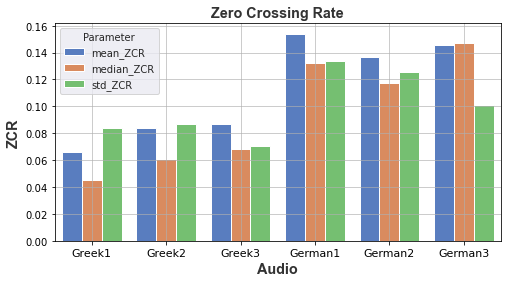

In [60]:
df_macro_rms = df_macro[['id','mean_ZCR','median_ZCR','std_ZCR']]
df_macro_rms_melt = pd.melt(df_macro_rms,id_vars=['id'],value_vars=['mean_ZCR', 'median_ZCR','std_ZCR'])
df_macro_rms_melt.rename(columns={'variable':'Parameter'},inplace=True)
dims = (8,4)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot(x=df_macro_rms_melt.id,y=df_macro_rms_melt.value,hue=df_macro_rms_melt.Parameter,palette='muted',order=['Greek1','Greek2','Greek3','German1','German2','German3'])
    #g = sns.barplot('Script_vs_Aurora_Error','value',hue='variable',data=script_vs_aurora_melt,palette=['#DB845B', '#5B73DB'],ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'])
    #g = sns.barplot('Script_vs_Aurora_Error','Error Mediana',data=script_vs_aurora,color='#5B73DB',ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'],label='Mediana')
    g.set_xlabel('Audio',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('ZCR',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    #g.set_yticks([0,50,100,150,200,250,300])
    g.set_title('Zero Crossing Rate',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Greek1','Greek2','Greek3','German1','German2','German3'],size=11)
    #g.set_yticklabels([0,50,100,150,200,250,300],size=11)
    g.grid(alpha=0.8)

In [62]:
df_macro.columns

Index(['id', 'emotion', 'mean_F0', 'std_F0', 'hnr', 'localJitter',
       'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
       'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'aqpq5Shimmer',
       'apq11Shimmer', 'ddaShimmer', 'median_F0', 'max_F0', 'min_F0',
       'mean_RMS', 'median_RMS', 'std_RMS', 'max_RMS', 'min_RMS', 'mean_ZCR',
       'median_ZCR', 'std_ZCR', 'max_ZCR', 'min_ZCR', 'mean_F0_mel',
       'std_F0_mel', 'max_F0_mel', 'min_F0_mel', 'median_F0_mel',
       'min_max_F0_difference'],
      dtype='object')

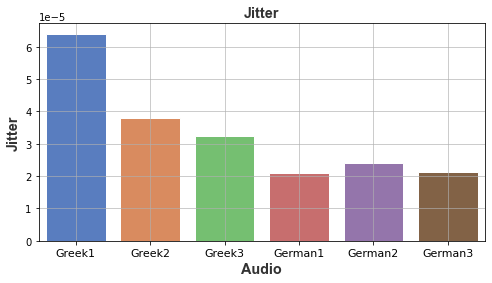

In [59]:
df_macro_rms = df_macro[['id','localabsoluteJitter']]
#df_macro_rms_melt = pd.melt(df_macro_rms,id_vars=['id'],value_vars=['localJitter','localShimmer'])
#df_macro_rms_melt.rename(columns={'variable':'Parameter'},inplace=True)
dims = (8,4)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot(x=df_macro_rms.id,y=df_macro_rms.localabsoluteJitter,palette='muted',order=['Greek1','Greek2','Greek3','German1','German2','German3'])
    #g = sns.barplot('Script_vs_Aurora_Error','value',hue='variable',data=script_vs_aurora_melt,palette=['#DB845B', '#5B73DB'],ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'])
    #g = sns.barplot('Script_vs_Aurora_Error','Error Mediana',data=script_vs_aurora,color='#5B73DB',ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'],label='Mediana')
    g.set_xlabel('Audio',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Jitter',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    #g.set_yticks([0,50,100,150,200,250,300])
    g.set_title('Jitter',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Greek1','Greek2','Greek3','German1','German2','German3'],size=11)
    #g.set_yticklabels([0,50,100,150,200,250,300],size=11)
    g.grid(alpha=0.8)

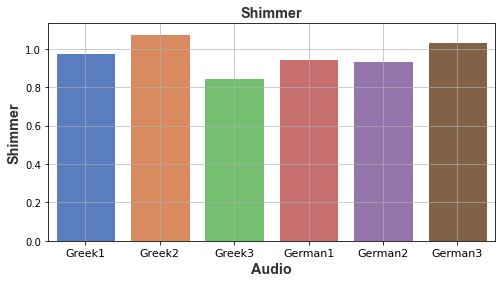

In [63]:
df_macro_rms = df_macro[['id','localdbShimmer']]
#df_macro_rms_melt = pd.melt(df_macro_rms,id_vars=['id'],value_vars=['localJitter','localShimmer'])
#df_macro_rms_melt.rename(columns={'variable':'Parameter'},inplace=True)
dims = (8,4)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot(x=df_macro_rms.id,y=df_macro_rms.localdbShimmer,palette='muted',order=['Greek1','Greek2','Greek3','German1','German2','German3'])
    #g = sns.barplot('Script_vs_Aurora_Error','value',hue='variable',data=script_vs_aurora_melt,palette=['#DB845B', '#5B73DB'],ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'])
    #g = sns.barplot('Script_vs_Aurora_Error','Error Mediana',data=script_vs_aurora,color='#5B73DB',ax=ax,saturation=0.9,order=['EDT', 'T20','T30','D50','C50','C80','IACC'],label='Mediana')
    g.set_xlabel('Audio',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Shimmer',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    #g.set_yticks([0,50,100,150,200,250,300])
    g.set_title('Shimmer',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticklabels(['Greek1','Greek2','Greek3','German1','German2','German3'],size=11)
    #g.set_yticklabels([0,50,100,150,200,250,300],size=11)
    g.grid(alpha=0.8)

#### Grafico de señales temporales

In [64]:
y_greek = []
y_german = []
time_greek = []
time_german = []

def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

for root, dirs, files in os.walk('Test', topdown=False):
    if files:
        for name in files:
            dataset = root.split('\\')[-1]
            if dataset == 'German':
                y,sr = lr.load(root + '\\' + name,sr=16000)
                y = y*(0.7/max(y))
                #y = y/max(y)
                sf.write(name, y, sr, 'PCM_24')
                y_german.append(y)
                time_german.append(np.linspace(0,len(y)/sr,len(y)))
            else:
                y,sr = lr.load(root + '\\' + name,sr=44100)
                y = y*(0.5/max(y))
                #y = y/max(y)
                sf.write(name, y, sr, 'PCM_24')
                y_greek.append(y)
                time_greek.append(np.linspace(0,len(y)/sr,len(y)))

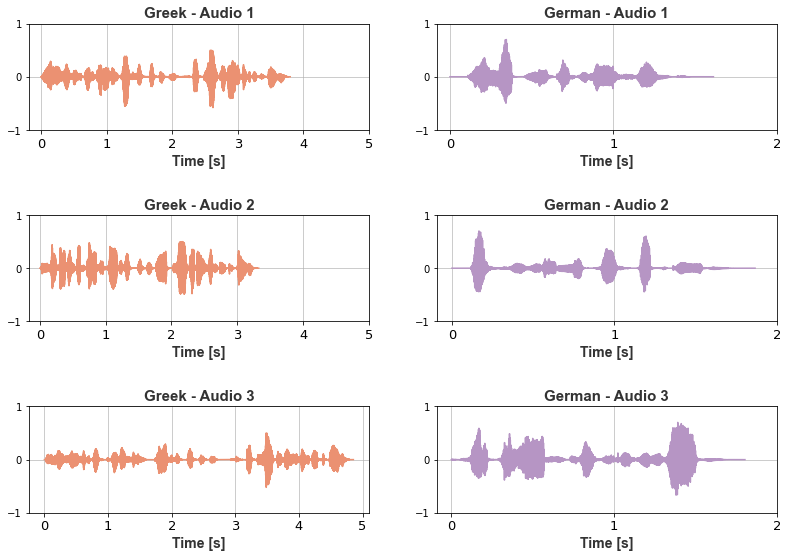

In [65]:
dims = (13.4,9)
fig,ax = plt.subplots(3,2,figsize=dims)
colors1 = sns.color_palette("RdBu", 10)
colors2 = sns.color_palette("PRGn", 10)
#with sns.axes_style('darkgrid'):
g = sns.lineplot(time_greek[0],y_greek[0],ax=ax[0,0],color=colors1[2])
g2 = sns.lineplot(time_greek[1],y_greek[1],ax=ax[1,0],color=colors1[2])
g3 = sns.lineplot(time_greek[2],y_greek[2],ax=ax[2,0],color=colors1[2])
g4 = sns.lineplot(time_german[0],y_german[0],ax=ax[0,1],color=colors2[2])
g5 = sns.lineplot(time_german[1],y_german[1],ax=ax[1,1],color=colors2[2])
g6 = sns.lineplot(time_german[2],y_german[2],ax=ax[2,1],color=colors2[2])
g.set_xlabel('Time [s]',weight='bold',size=14,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g2.set_xlabel('Time [s]',weight='bold',size=14,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g3.set_xlabel('Time [s]',weight='bold',size=14,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g4.set_xlabel('Time [s]',weight='bold',size=14,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g5.set_xlabel('Time [s]',weight='bold',size=14,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g6.set_xlabel('Time [s]',weight='bold',size=14,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g.set_yticks([-1,0,1])
g2.set_yticks([-1,0,1])
g3.set_yticks([-1,0,1])
g4.set_yticks([-1,0,1])
g5.set_yticks([-1,0,1])
g6.set_yticks([-1,0,1])
g.set_xticks([0,1,2,3,4,5])
g2.set_xticks([0,1,2,3,4,5])
g3.set_xticks([0,1,2,3,4,5])
g4.set_xticks([0,1,2])
g5.set_xticks([0,1,2])
g6.set_xticks([0,1,2])
g.set_xticklabels(['0','1','2','3','4','5'],size=13)
g2.set_xticklabels(['0','1','2','3','4','5'],size=13)
g3.set_xticklabels(['0','1','2','3','4','5'],size=13)
g4.set_xticklabels(['0','1','2'],size=13)
g5.set_xticklabels(['0','1','2'],size=13)
g6.set_xticklabels(['0','1','2'],size=13)
g.set_title('Greek - Audio 1',weight='bold',size=15,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g2.set_title('Greek - Audio 2',weight='bold',size=15,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g3.set_title('Greek - Audio 3',weight='bold',size=15,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g4.set_title('German - Audio 1',weight='bold',size=15,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g5.set_title('German - Audio 2',weight='bold',size=15,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g6.set_title('German - Audio 3',weight='bold',size=15,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g.grid(alpha=0.8)
g2.grid(alpha=0.8)
g3.grid(alpha=0.8)
g4.grid(alpha=0.8)
g5.grid(alpha=0.8)
g6.grid(alpha=0.8)



plt.subplots_adjust(hspace=0.8)

(0.5, 0.525)

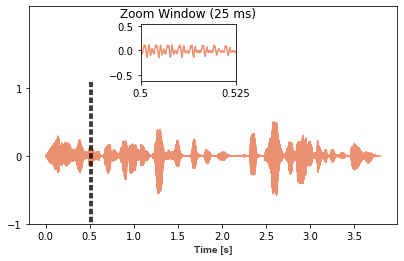

In [66]:
dims = (6.6,4)
fig,ax1 = plt.subplots(figsize=dims)


    #g = sns.barplot(x=['Audio 1','Audio 2','Audio 3'],y=df_macro_german.std_F0_mel.sort_values(),palette='muted')
g = sns.lineplot(time_greek[0],y_greek[0],color=colors1[2],ax=ax1)
g.set_xlabel('Time [s]',weight='bold',size=10,alpha=0.8,family= 'Arial',stretch='extra-expanded')
g.set_yticks([-1,0,1])
#g.set_xticklabels(['0.5', '0.525'])
ax1.set_ylim([-1,2.2])
plt.axvline(0.5, -1,0.65,color='black',linestyle='dashed')
plt.axvline(0.525, -1,0.65,color='black',linestyle='dashed')
#sns.lineplot(time_greek[0],y_greek2,color=colors1[1],ax=ax2)


ax2 = plt.axes([0.36, 0.62, .2, .2], facecolor='w')
z = sns.lineplot(time_greek[0],y_greek[0], ax=ax2, color = colors1[2])
z.set_xticks([0.5,0.525])
z.set_xticklabels(['0.5', '0.525'])
#z.set_xlabel('25 ms',weight='bold',size=10,alpha=0.8,family= 'Arial',stretch='extra-expanded')
ax2.set_title('Zoom Window (25 ms)')
ax2.set_xlim([0.5,0.525])